# Testing/Classify the classifications
I will find the different structural features and development features of the three classifications, both in terms of mean and variance within the class.

In [1]:
import os
os.chdir("../..") # Change to parent directory
from struc2vec.src.Helpers import *
os.chdir("structuralNetworkMigration")

In [40]:
import statsmodels.api as sm
import numpy as np
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import matplotlib as mpl

## Load graph and classifications

In [3]:
G = nx.read_gexf("data/Graphs/bynode_0_directed.gexf")

In [4]:
with open("data/embeddings/node2class.json", "r") as f:
    class_data = json.load(f)

In [5]:
df_struc_feat, df_struc_feat_grouped = get_meta_data(G, class_data.keys(), class_data.values())

## Create table of structural features grouped by classification

In [6]:
df_struc_feat.describe().T

,count,mean,std,min,25%,50%,75%,max
Embedding,226.0,1.000000,0.858940,0.000000,0.000000,1.000000,2.000000,2.000000
Clustering,226.0,0.612844,0.161953,0.234189,0.528562,0.611871,0.703280,1.000000
Betweenness_centrality,226.0,0.003656,0.011166,0.000000,0.000022,0.000349,0.002011,0.088446
Closeness_centrality,226.0,0.447966,0.225726,0.000000,0.418802,0.501114,0.537956,0.918367
InDegree,226.0,36.712389,50.844701,0.000000,5.000000,17.000000,38.750000,205.000000
OutDegree,226.0,36.712389,23.397085,1.000000,20.000000,35.500000,51.000000,128.000000
Average_weight,226.0,12.846571,46.952251,0.021500,0.544010,1.556744,5.501317,452.658628


In [7]:
df_list = []
for class_, df_class in df_struc_feat.groupby("Embedding"):
    struc_data_ = df_class.drop("Embedding", axis=1).describe().T
    index_tup = [(feat_, class_) for feat_ in struc_data_.index]
    index_ = pd.MultiIndex.from_tuples(index_tup)
    struc_data_.index = index_
    df_list.append(struc_data_)

In [8]:
struc_feat = pd.concat(df_list)
index_sort = sorted(struc_feat.index)
latex_table = struc_feat.loc[index_sort].apply(lambda x: round(x,2)).to_latex()

## Create histograms

In [31]:
# fig, ax = plt.subplots(2,3, figsize=[17,10])
# sns.histplot(df_struc_feat[df_struc_feat["Embedding"] == 0]["Clustering"], ax=ax[0,0])
# ax[0,0].set_xlim(0,1)
# ax[0,0].set_ylim(ymin=0,ymax=None)
# ax[0,0].set_title("Class 0")
# ax[0,0].set_xlabel("Clust!")

In [32]:
plot_settings = {
    "Clustering":
        {"ymin":None,"ymax":25,
        "xmin":0,"xmax":1,
        "xlabel":"Clustering"},
    "Betweenness_centrality":
        {"ymin":None,"ymax":36,
        "xmin":0,"xmax":0.09,
        "xlabel": "Betweenness centrality"},
    "Closeness_centrality":
        {"ymin":None,"ymax":40,
        "xmin":0,"xmax":1,
        "xlabel":"Closeness centrality"},
    "InDegree":
        {"ymin":None,"ymax":35,
        "xmin":0,"xmax":200,
        "xlabel":"In-degree"},
    "OutDegree":
        {"ymin":None,"ymax":25,
        "xmin":0,"xmax":125,
        "xlabel":"Out-degree"},
    "Average_weight":
        {"ymin":None,"ymax":None,
        "xmin":None,"xmax":None,
        "xlabel":"Average weight"},
                  }

In [33]:
data_dict = {0:df_struc_feat[df_struc_feat["Embedding"] == 0],
             1: df_struc_feat[df_struc_feat["Embedding"] == 1],
             2: df_struc_feat[df_struc_feat["Embedding"] == 2]}

In [34]:
struc_feat_columns =list(df_struc_feat.columns)[2:]

In [43]:
emb2label = {0:"Peripheral", 1:"Core", 2:"Semi-peripheral",999:"No data"}

In [45]:
df_struc_feat["Label"] = [emb2label[emb] for emb in df_struc_feat["Embedding"]]

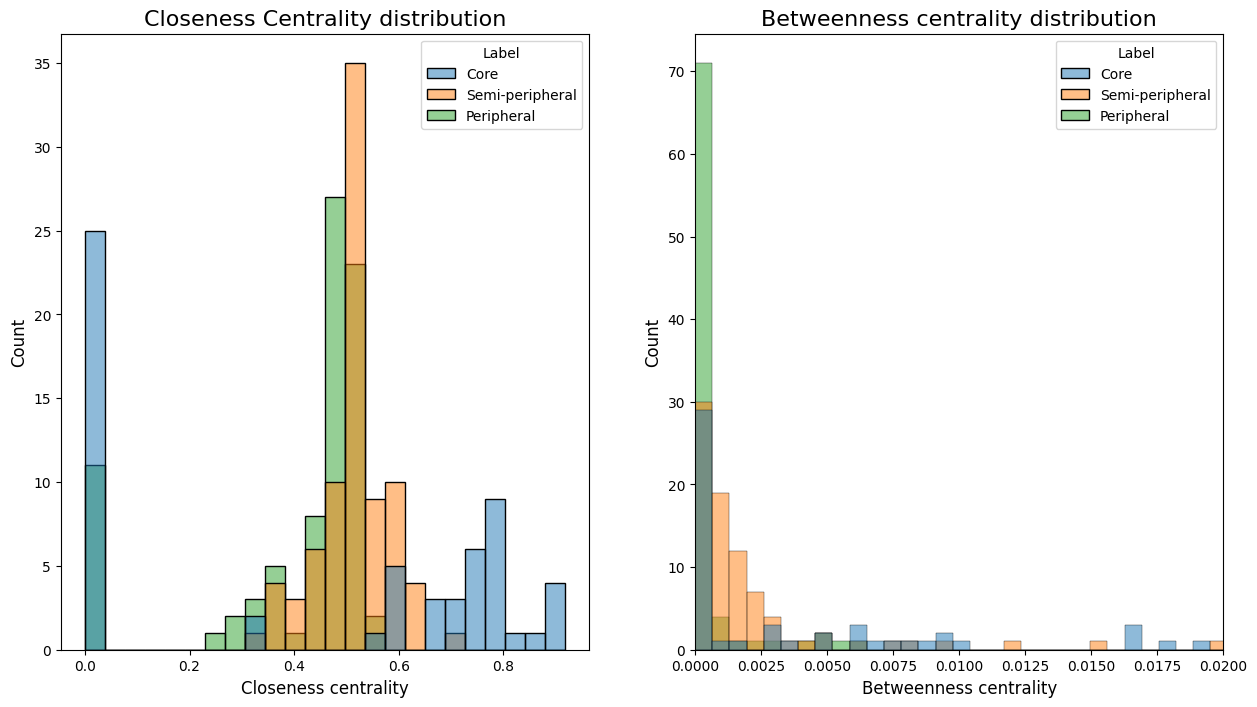

In [75]:
fig, ax = plt.subplots(1,2, figsize=[15,8])
sns.histplot(data=df_struc_feat, x="Closeness_centrality", hue="Label", ax=ax[0])
ax[0].set_title("Closeness Centrality distribution", fontsize=16)
ax[0].set_xlabel("Closeness centrality", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)

sns.histplot(data=df_struc_feat, x="Betweenness_centrality", hue="Label", ax=ax[1])
ax[1].set_title("Betweenness centrality distribution", fontsize=16)
ax[1].set_xlabel("Betweenness centrality", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].set_xlim(xmin=0.0, xmax=0.02)
plt.savefig("visuals/Centrality.png")
plt.show()

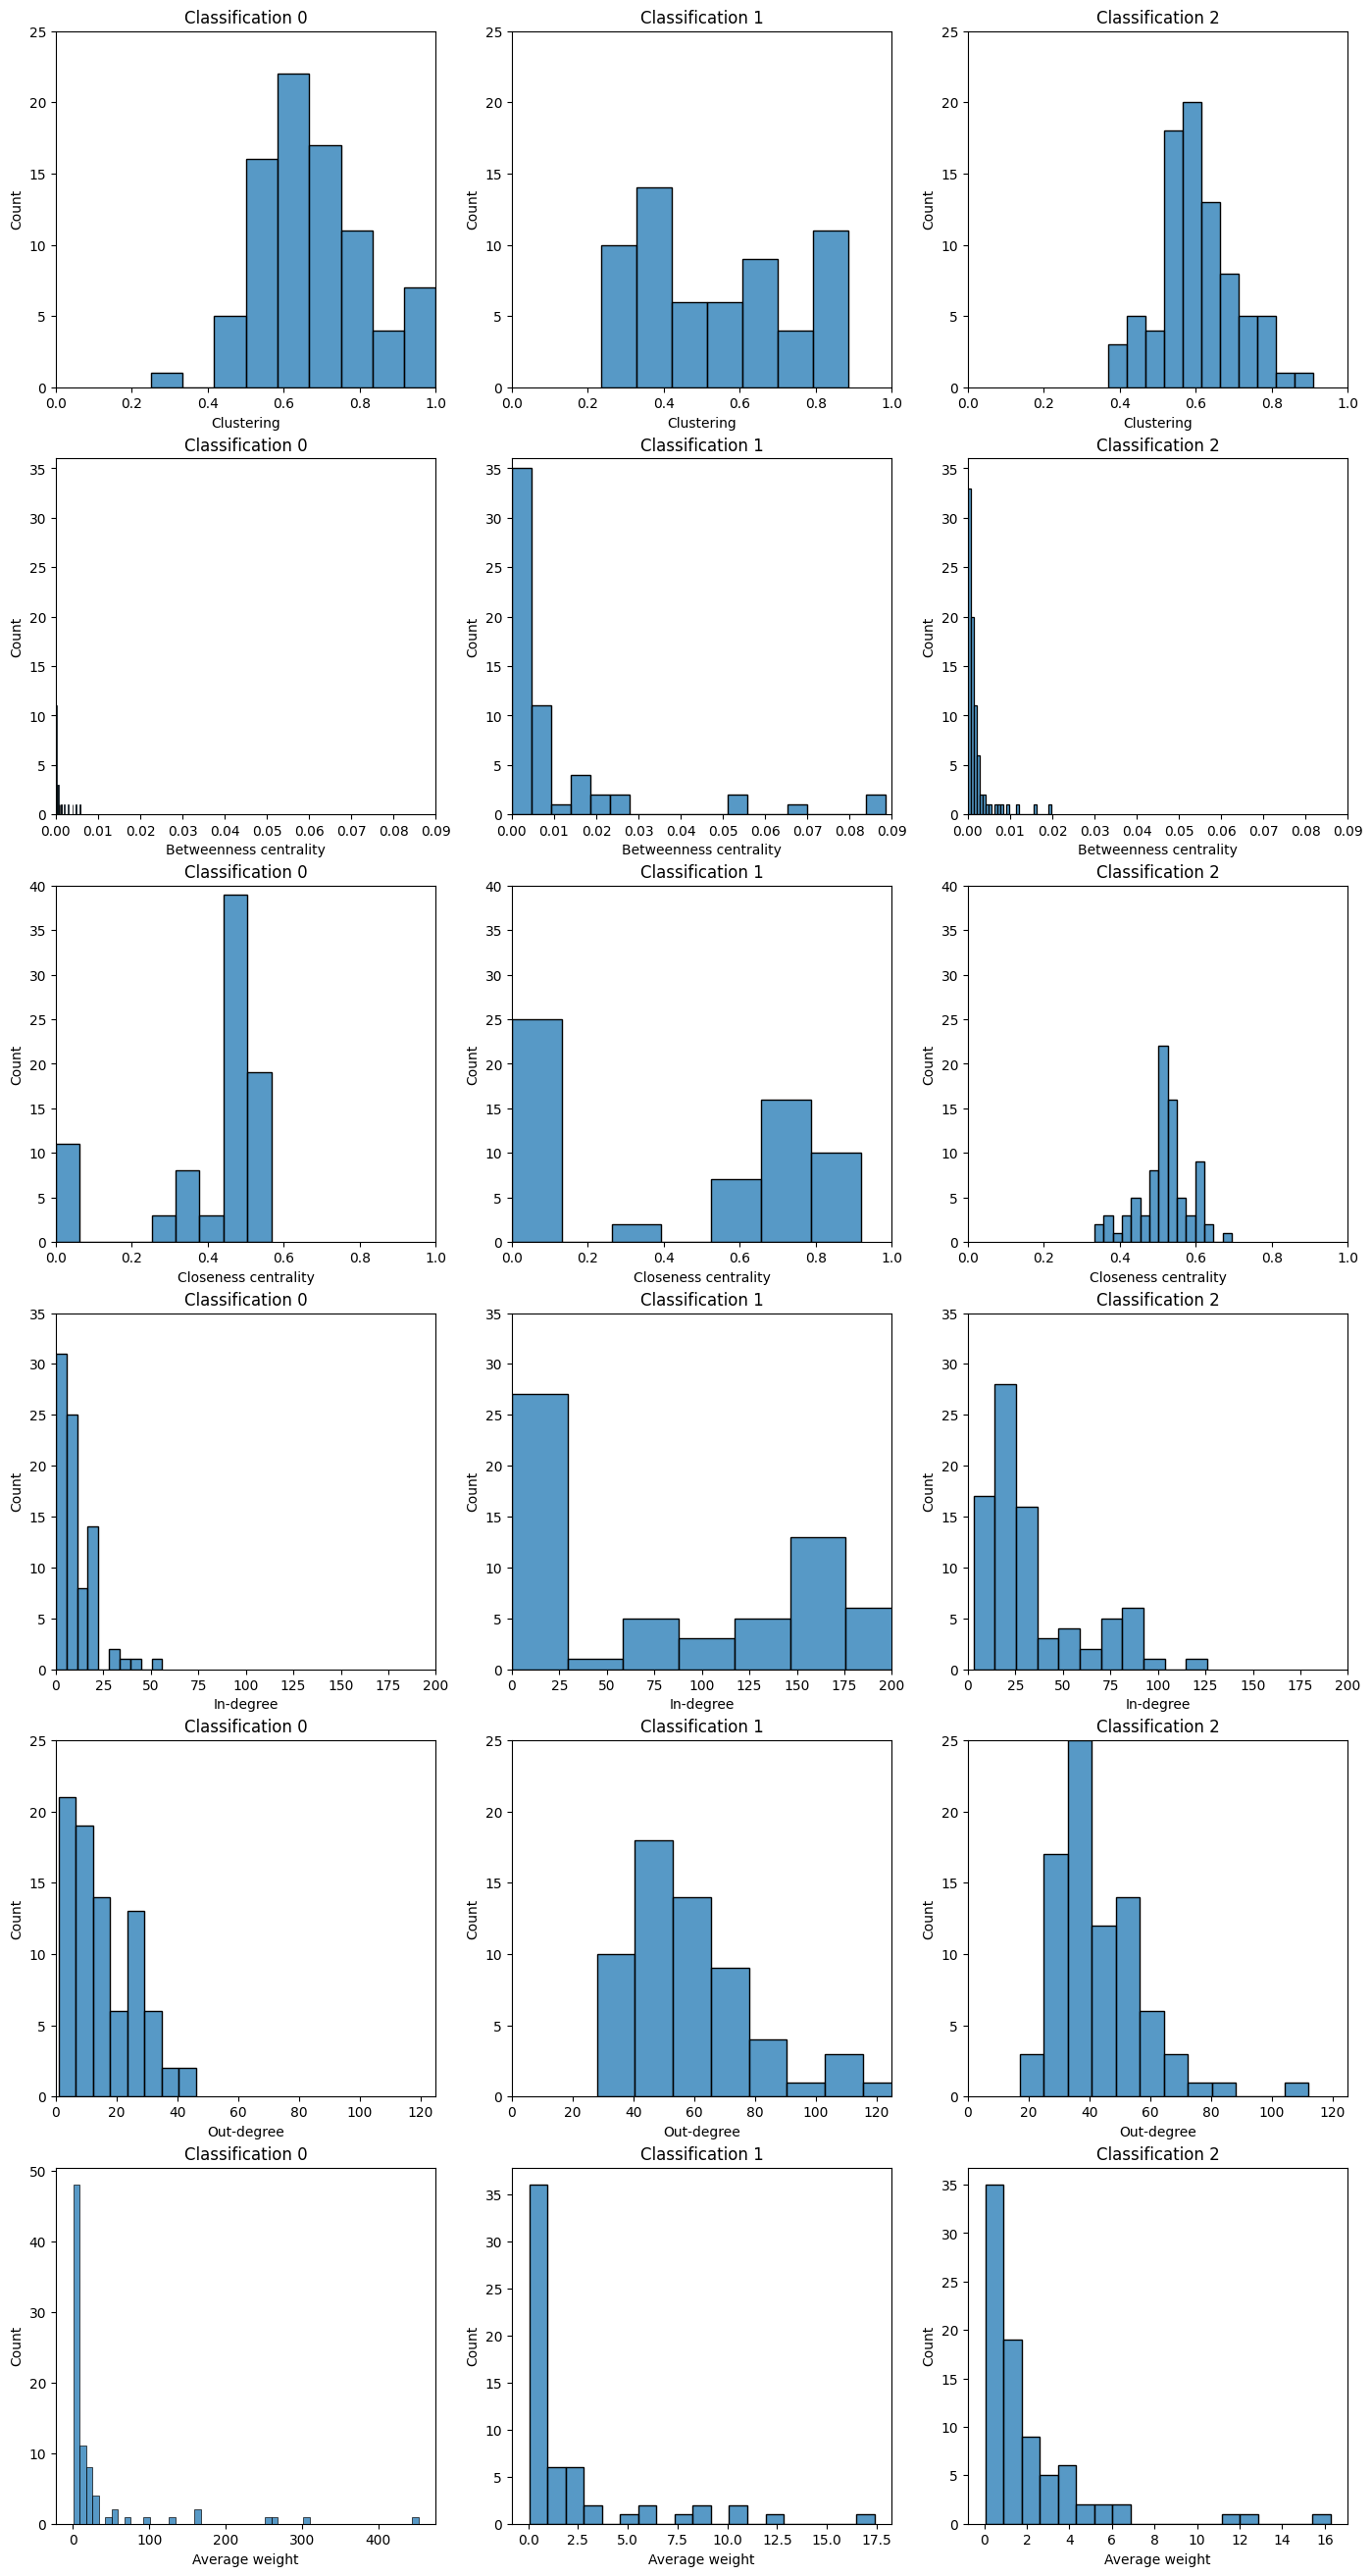

In [35]:
fig, ax = plt.subplots(6,3, figsize=[17,33])

for i, column_ in enumerate(struc_feat_columns):
    ymin = plot_settings[column_]["ymin"]
    ymax = plot_settings[column_]["ymax"]
    xmin = plot_settings[column_]["xmin"]
    xmax = plot_settings[column_]["xmax"]
    xlabel = plot_settings[column_]["xlabel"]
    for j in range(3):
        data_ = data_dict[j]
        sns.histplot(data_[column_], ax=ax[i,j])
        ax[i,j].set_title(f"Classification {j}")
        ax[i,j].set_ylim(ymin=ymin,ymax=ymax)
        ax[i,j].set_xlim(xmin=xmin,xmax=xmax)
        ax[i,j].set_xlabel(xlabel)
# plt.savefig("visuals/struc_feat_histplot.jpg")
plt.show()

## Describe development features

In [14]:
df_dev = pd.read_csv("data/metadata_country/metadata_full.csv").set_index("Node", drop=True)

In [15]:
df_dev["GDP (Billion $)"] = df_dev["GDP"] / 1000000000

In [16]:
df_dev["Class"] = df_dev["Class"].apply(int)

In [17]:
df_dev_econ = df_dev[["Class", "Human Development Index (value)", "Mean Years of Schooling (years)", "Expected Years of Schooling (years)", "GDP (Billion $)" ]]

In [18]:
df_dev_fert = df_dev.iloc[:,[0,-6,-5,-4,-3]]

In [19]:
df_dev_fert

,Class,GDP,"Fertility rate, total (births per woman)","Mortality rate, adult, female (per 1,000 female adults)","Mortality rate, adult, male (per 1,000 male adults)"
Node,,,,,
AFG,1,1.875346e+10,5.405,209.573,278.424
AUS,1,1.330000e+12,1.814,45.231,78.367
AUT,1,4.170000e+11,1.490,44.687,84.688
BHR,2,3.542364e+10,2.131,51.933,64.528
BEL,1,5.030000e+11,1.700,53.983,89.437
...,...,...,...,...,...
TON,0,4.603744e+08,3.562,156.780,237.489
TKM,0,3.792629e+10,2.930,120.273,236.782
UZB,1,6.208132e+10,2.491,121.508,212.748


In [20]:
cur_df_dev = df_dev_fert
df_list = []
for class_, df_class in cur_df_dev.groupby("Class"):
    dev_data_ = df_class.drop("Class", axis=1).describe().T
    index_tup = [(feat_, class_) for feat_ in dev_data_.index]
    index_ = pd.MultiIndex.from_tuples(index_tup)
    dev_data_.index = index_
    df_list.append(dev_data_)

In [21]:
dev_feat = pd.concat(df_list)
index_sort = sorted(dev_feat.index)
latex_table = dev_feat.loc[index_sort]

In [22]:
latex_table

count          mean  \
Fertility rate, total (births per woman)           0   63.0  2.966294e+00   
                                                   1   60.0  2.099642e+00   
                                                   2   83.0  3.010217e+00   
GDP                                                0   63.0  8.023662e+09   
                                                   1   59.0  9.508423e+11   
                                                   2   83.0  2.883804e+11   
Mortality rate, adult, female (per 1,000 female... 0   60.0  1.547447e+02   
                                                   1   59.0  8.369385e+01   
                                                   2   83.0  1.383351e+02   
Mortality rate, adult, male (per 1,000 male adu... 0   60.0  2.290100e+02   
                                                   1   59.0  1.477900e+02   
                                                   2   83.0  2.121088e+02   

                                                               std  \
Fertility rate, total (births per woman)           0  1.307041e+00   
                                                   1  9.028318e-01   
                                                   2  1.527698e+00   
GDP                                                0  1.636425e+10   
                                                   1  2.661884e+12   
                                                   2  1.360739e+12   
Mortality rate, adult, female (per 1,000 female... 0  9.995445e+01   
                                                   1  5.978247e+01   
                                                   2  8.495327e+01   
Mortality rate, adult, male (per 1,000 male adu... 0  1.114231e+02   
                                                   1  8.480575e+01   
                                                   2  9.571462e+01   

                                                               min  \
Fertility rate, total (births per woman)           0  1.186000e+00   
                                                   1  1.240000e+00   
                                                   2  1.196000e+00   
GDP                                                0  4.527660e+07   
                                                   1  7.536403e+09   
                                                   2  1.504909e+09   
Mortality rate, adult, female (per 1,000 female... 0  2.794300e+01   
                                                   1  2.926000e+01   
                                                   2  2.631600e+01   
Mortality rate, adult, male (per 1,000 male adu... 0  5.490900e+01   
                                                   1  5.366300e+01   
                                                   2  5.060000e+01   

                                                               25%  \
Fertility rate, total (births per woman)           0  1.902500e+00   
                                                   1  1.537500e+00   
                                                   2  1.863500e+00   
GDP                                                0  1.101562e+09   
                                                   1  5.387649e+10   
                                                   2  1.522954e+10   
Mortality rate, adult, female (per 1,000 female... 0  7.306300e+01   
                                                   1  4.602650e+01   
                                                   2  7.377150e+01   
Mortality rate, adult, male (per 1,000 male adu... 0  1.621803e+02   
                                                   1  7.787300e+01   
                                                   2  1.421090e+02   

                                                               50%  \
Fertility rate, total (births per woman)           0  2.494000e+00   
                                                   1  1.777000e+00   
                                                   2  2.534000e+00   
GDP                                    

In [23]:
s = latex_table.style

In [24]:
s.format({
    "count":'{:.0f}',
    }).format("{:.2f}",
        subset=latex_table.columns[1:]
    )

In [25]:
print(s.to_latex())

\begin{tabular}{llrrrrrrrr}
 &  & count & mean & std & min & 25% & 50% & 75% & max \\
\multirow[c]{3}{*}{Fertility rate, total (births per woman)} & 0 & 63 & 2.97 & 1.31 & 1.19 & 1.90 & 2.49 & 4.13 & 6.04 \\
 & 1 & 60 & 2.10 & 0.90 & 1.24 & 1.54 & 1.78 & 2.27 & 5.41 \\
 & 2 & 83 & 3.01 & 1.53 & 1.20 & 1.86 & 2.53 & 3.97 & 7.21 \\
\multirow[c]{3}{*}{GDP} & 0 & 63 & 8023662295.32 & 16364247259.39 & 45276595.35 & 1101562471.00 & 2851613679.00 & 6222135682.50 & 103000000000.00 \\
 & 1 & 59 & 950842303559.63 & 2661883676466.08 & 7536402853.00 & 53876491468.00 & 248000000000.00 & 618000000000.00 & 19600000000000.00 \\
 & 2 & 83 & 288380430377.52 & 1360739298568.67 & 1504909463.00 & 15229535104.50 & 41283617976.00 & 141000000000.00 & 12300000000000.00 \\
\multirow[c]{3}{*}{Mortality rate, adult, female (per 1,000 female adults)} & 0 & 60 & 154.74 & 99.95 & 27.94 & 73.06 & 129.05 & 213.87 & 482.66 \\
 & 1 & 59 & 83.69 & 59.78 & 29.26 & 46.03 & 59.73 & 93.07 & 306.19 \\
 & 2 & 83 & 138.34 & 84.

In [26]:
plot_settings = {
    "Fertility rate, total (births per woman)":
        {"ymin":None,"ymax":35,
        "xmin":1,"xmax":7},
    "Mortality rate, adult, female (per 1,000 female adults)":
        {"ymin":None,"ymax":40,
        "xmin":0,"xmax":500},
    "Mortality rate, adult, male (per 1,000 male adults)":
        {"ymin":None,"ymax":42,
        "xmin":0,"xmax":600},
    "Mortality rate, infant (per 1,000 live births)":
        {"ymin":None,"ymax":60,
        "xmin":0,"xmax":82},   
                  }

In [27]:
cur_df_dev = df_dev_fert
data_dict = {0:cur_df_dev[cur_df_dev["Class"] == 0],
             1: cur_df_dev[cur_df_dev["Class"] == 1],
             2: cur_df_dev[cur_df_dev["Class"] == 2]}

dev_columns =list(cur_df_dev.columns)[1:]


In [28]:
dev_columns

['GDP',
 'Fertility rate, total (births per woman)',
 'Mortality rate, adult, female (per 1,000 female adults)',
 'Mortality rate, adult, male (per 1,000 male adults)']

KeyError: 'GDP'

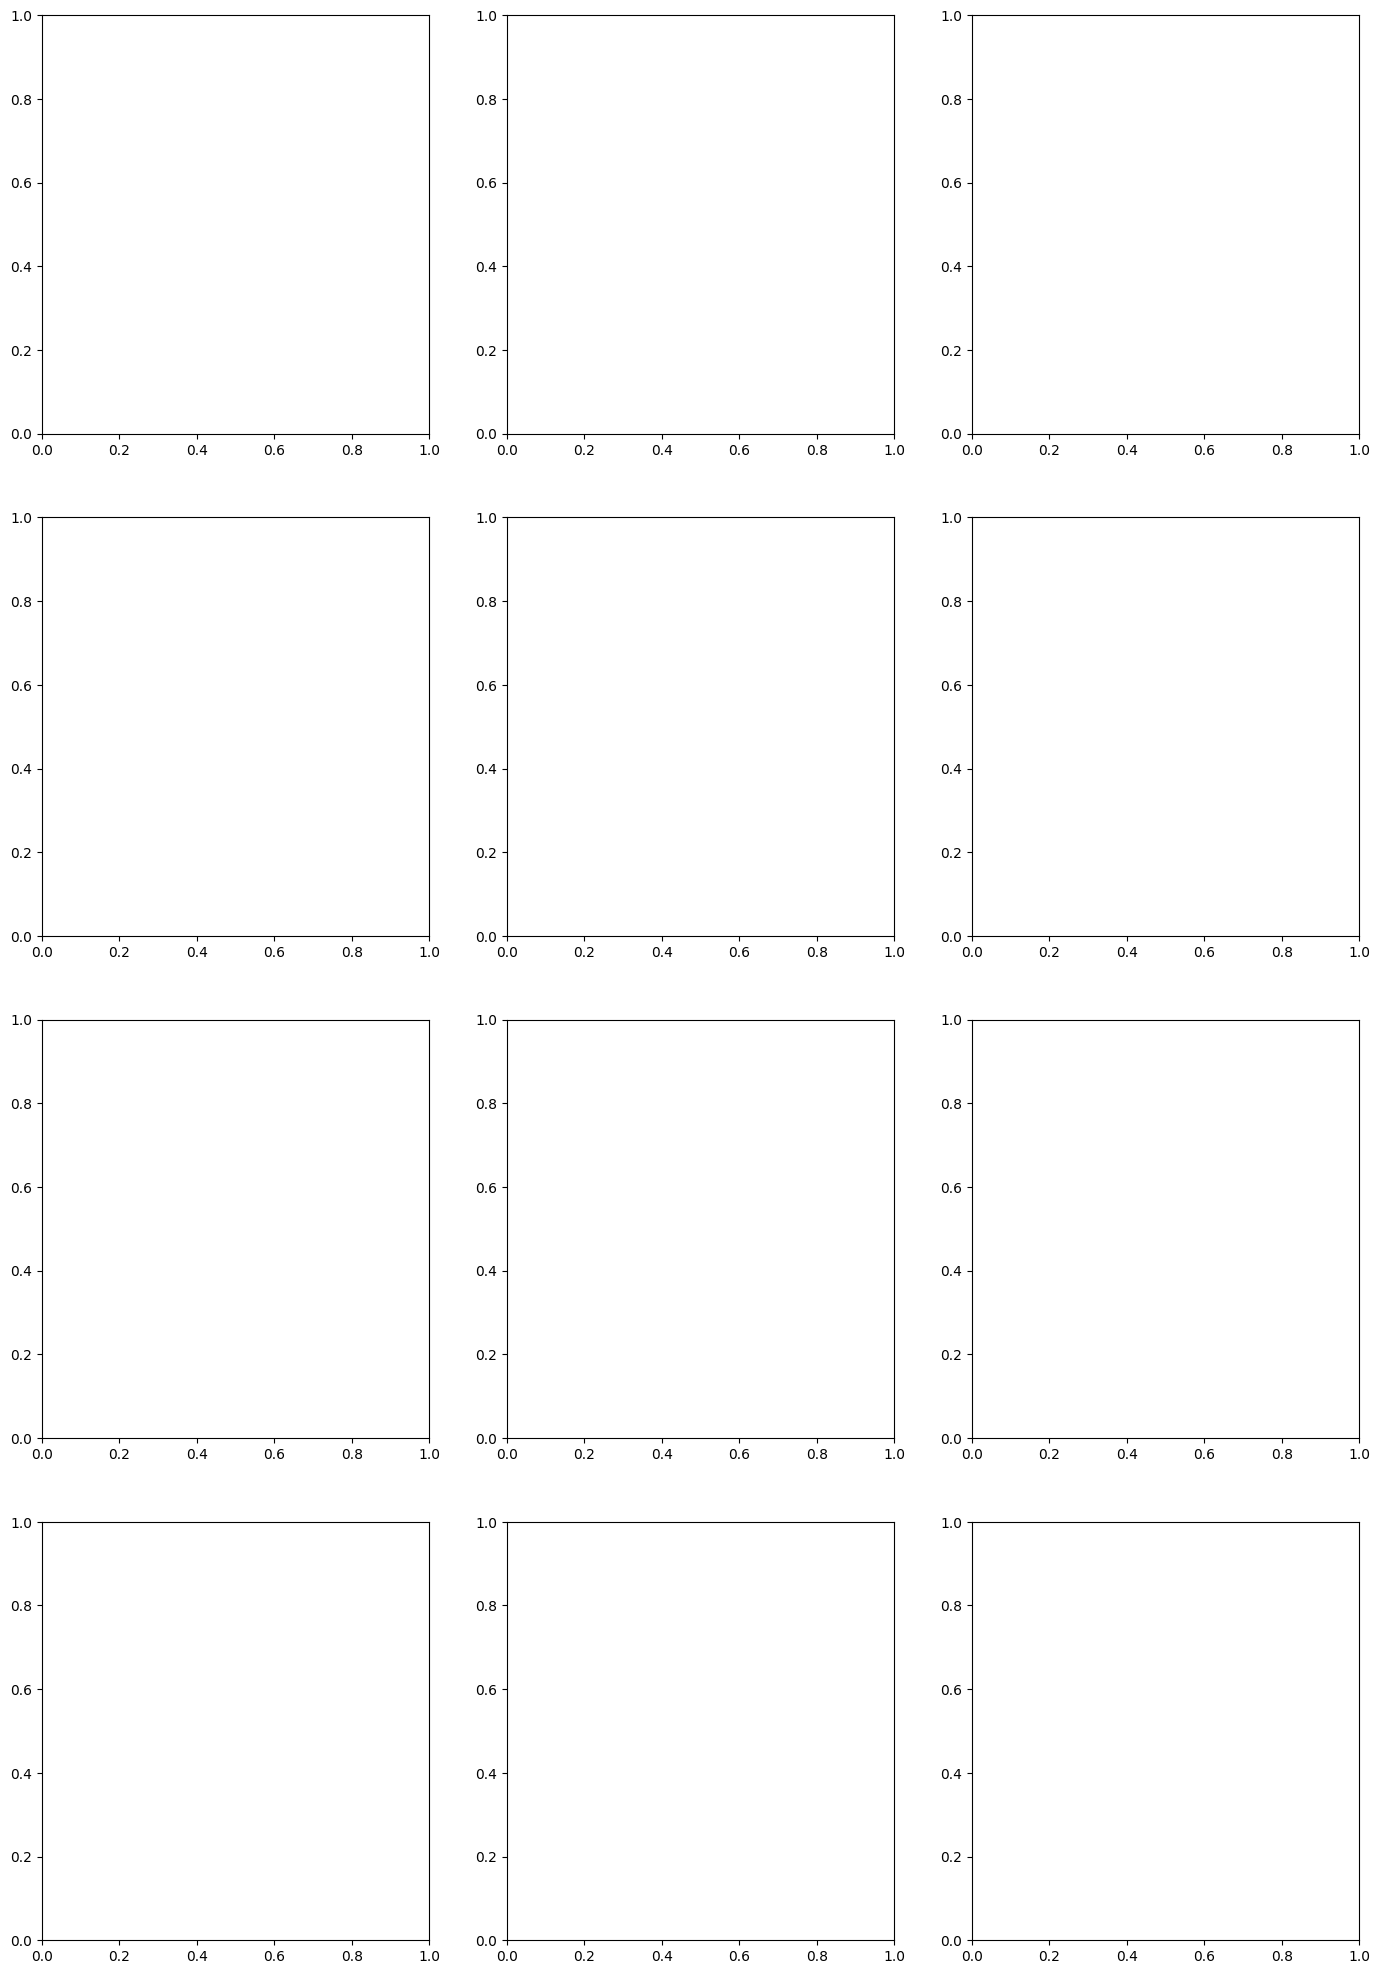

In [29]:
fig, ax = plt.subplots(4,3, figsize=[17,25])

for i, column_ in enumerate(dev_columns):
    ymin = plot_settings[column_]["ymin"]
    ymax = plot_settings[column_]["ymax"]
    xmin = plot_settings[column_]["xmin"]
    xmax = plot_settings[column_]["xmax"]
    for j in range(3):
        data_ = data_dict[j]
        sns.histplot(data_[column_], ax=ax[i,j],stat="percent")
        ax[i,j].set_title(f"Classification {j}, (n={sum(data_[column_].notna())})")
        ax[i,j].set_ylim(ymin=ymin,ymax=ymax)
        ax[i,j].set_xlim(xmin=xmin,xmax=xmax)
# plt.savefig("visuals/dev_fert_histplot.jpg")
plt.show()